In [10]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Bring in data

In [2]:
df = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
solutions = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
df_labeled = df.merge(solutions, how='inner', on='participant_id')


In [241]:
df_labeled.iloc[:,1:-2].values.shape

(1213, 19900)

## Transform to arrays

In [4]:
region_pairs = []
for col in df_labeled.columns:
    try:
        i, j = col.split('throw_')
        i = int(i)  # Convert "0throw" → 0
        j = int(j.replace('thcolumn', ''))  # Convert "2thcolumn" → 2
        region_pairs.append((i, j))
    except ValueError:
        print(f"Skipping malformed column: {col}")

region_pairs = np.array(region_pairs)


Skipping malformed column: participant_id
Skipping malformed column: ADHD_Outcome
Skipping malformed column: Sex_F


In [5]:
def reshape_to_matrix(patient_data):
    matrix = np.zeros((199, 199))  # Initialize 199x199 matrix
    
    for idx, (i, j) in enumerate(region_pairs):
        matrix[i, j - 1] = patient_data[idx]  # Subtract 1 from j

    return matrix


In [6]:
connectomes = np.array([reshape_to_matrix(row) for _, row in df.iloc[:,1:].iterrows()])

/var/folders/9v/6bsrztp11777s06bs8q25y2h0000gn/T/ipykernel_28801/1768268947.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  matrix[i, j - 1] = patient_data[idx]  # Subtract 1 from j


In [432]:
df_labeled.head(1)

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,-0.050968,-0.014365,0.128066,0.112646,-0.05898,0.028228,0.133582,0.143372,1,0


In [204]:
# (# of participants, rows, columns in grid)
pd.Series(connectomes[540].flatten())

0       -0.108068
1        0.091754
2       -0.002836
3        0.017706
4        0.130521
           ...   
39596    0.000000
39597    0.000000
39598    0.000000
39599    0.000000
39600    0.034577
Length: 39601, dtype: float64

## Labels

In [7]:
adhd_idx = df_labeled[df_labeled['ADHD_Outcome']==1].index.tolist()
no_adhd_idx = df_labeled[df_labeled['ADHD_Outcome']==0].index.tolist()

# Feature Eng

## Standardized difference (Cohen's d-like measure)

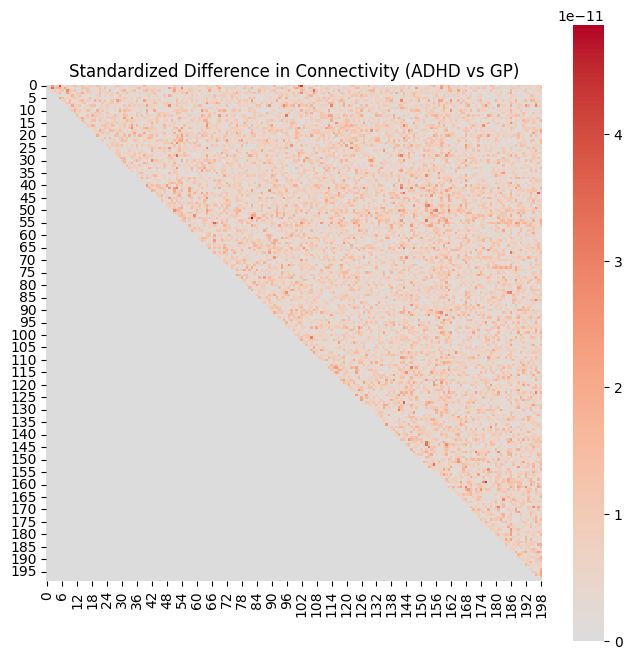

<Axes: >

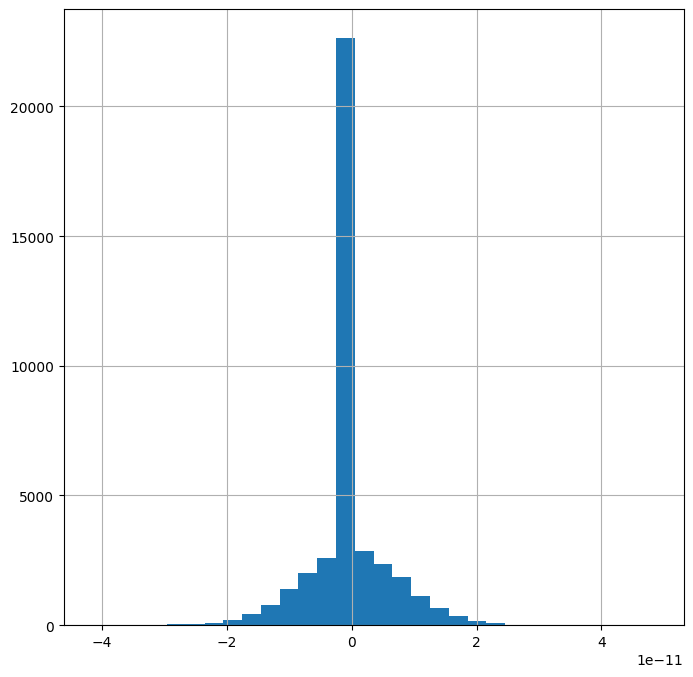

In [21]:

plt.figure(figsize=(8,8))
# Get standard deviations for each group
adhd_std = np.std(connectomes[adhd_idx], axis=0)
pop_std = np.std(connectomes, axis=0)

adhd_mean = np.mean(connectomes[adhd_idx], axis=0)
pop_mean = np.mean(connectomes, axis=0)
epsilon = 1e8 # what they say to use for ML. 1e10 is fine too though

# Pooled standard deviation
n_adhd = len(adhd_idx)
n_control = len(no_adhd_idx)

# pooled_std = np.sqrt(((n_adhd-1)*adhd_std**2 + (n_control-1)*control_std**2) / 
#                      (n_adhd + n_control - 2))

# Standardized difference
effect_size = (adhd_mean - pop_mean) / (pop_std+ epsilon)

# Plot standardized difference
sns.heatmap(abs(effect_size), cmap='coolwarm', square=True, 
            cbar=True, center=0)#, vmin=-2, vmax=2)
plt.title('Standardized Difference in Connectivity (ADHD vs GP)')
#plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
pd.Series((effect_size).flatten()).hist(bins=30)


Trying something a bit different. Let's look only at the extreme ends of the effect size being different, and see if we break out ADHD differently... (i.e. group by ADHD and see some separation)

In [309]:
# only looking at the extreme ends of effect sizes being different than the population mean. This shrinks down the number of connections to consider for feature engineering, hopefully reducing noise and improving grouping.
ends_bool_array = ((effect_size > effect_size.mean() + effect_size.std()*2) | (effect_size < effect_size.mean() - effect_size.std()*2))
middle_bool_array = ((effect_size <= effect_size.mean() + effect_size.std()*2) & (effect_size >= effect_size.mean() - effect_size.std()*2))

In [340]:
connectomes[0, ends_bool_array].shape[0]/connectomes[0, middle_bool_array].shape[0]

0.08025314383916637

In [426]:
(199*199/2)**2 #392,059,800

392059800.25

### Per patient

<Axes: >

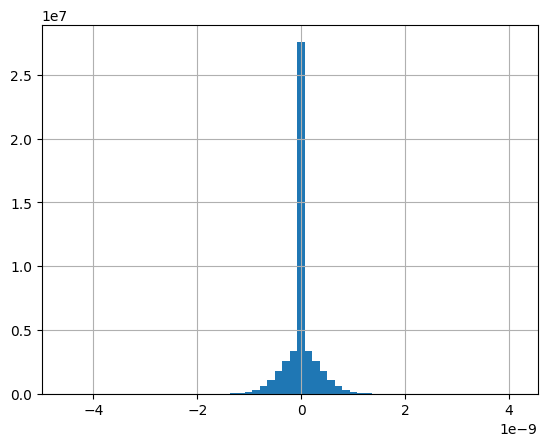

In [54]:
es_per_patient= (connectomes - pop_mean) / (pop_std+ epsilon)
pd.Series(((connectomes - pop_mean) / (pop_std+ epsilon)).flatten()).hist(bins=60)

In [52]:
pd.Series(((connectomes - pop_mean) / (pop_std+ epsilon))[0].flatten()).value_counts()

 0.000000e+00    19701
 3.292041e-10        1
 2.219100e-10        1
 6.673067e-11        1
-4.777437e-10        1
                 ...  
-5.068687e-10        1
-4.421414e-11        1
-1.090922e-10        1
 1.935371e-10        1
 1.442625e-10        1
Name: count, Length: 19901, dtype: int64

In [51]:
199*199

39601

In [53]:

# for thresh in np.arange(.1,.25,.05):
#     plt.figure()
#     hold = []

#     for i in np.arange(connectomes.shape[0]):
#         hold.append(np.sum(np.abs(get_upper_triangle_features(connectomes[i]))>=thresh))
    
#     pd.Series(hold).hist(alpha=.5, label=f'{thresh}')
#     plt.legend()

## Connection isolation (varied techniques)

In [436]:
def get_upper_triangle_features(matrix):
    # Get upper triangle indices
    indices = np.triu_indices_from(matrix, k=1)  # k=1 excludes diagonal
    # Return the values at these indices
    return matrix[indices]#, indices

Below I tried both effect size and a version with the non-transformed, raw values (no need to standardize bc they're all kinda the same).

Trying just with the values as is - no fancy transformation..

Trying UMAP with ONLY the regions more than 2 std above or below the normal effect size for the pop...

In [246]:
# connectomes2 = df_labeled.iloc[:,1:-2].values
# vals = connectomes2.copy()
#vals = np.array([get_upper_triangle_features(conn) for conn in connectomes])

In [384]:
connectomes[:,ends_bool_array][no_adhd_idx]

array([[ 0.07352272,  0.02482056,  0.08367656, ...,  0.07208147,
        -0.06958449, -0.06520445],
       [ 0.16134794,  0.02905375,  0.06439268, ...,  0.00372105,
        -0.09184149,  0.16933551],
       [-0.00696261,  0.12442543,  0.17369749, ...,  0.1006391 ,
         0.06447633,  0.19994346],
       ...,
       [-0.00651432,  0.09336454,  0.08336855, ...,  0.11858671,
         0.12444259,  0.11306377],
       [ 0.06196393,  0.07827767,  0.10585701, ...,  0.1434456 ,
         0.12749476, -0.036065  ],
       [ 0.0831834 ,  0.03487052, -0.04643841, ..., -0.07009384,
        -0.03666894,  0.02298898]])

0.007212647390012733
3.2278575465041977e-35
1374222919793.0
0.6304388318640985


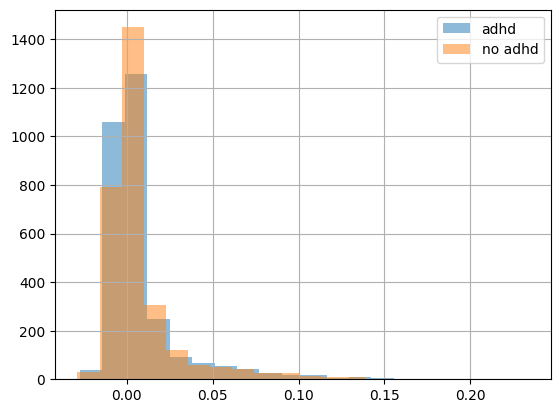

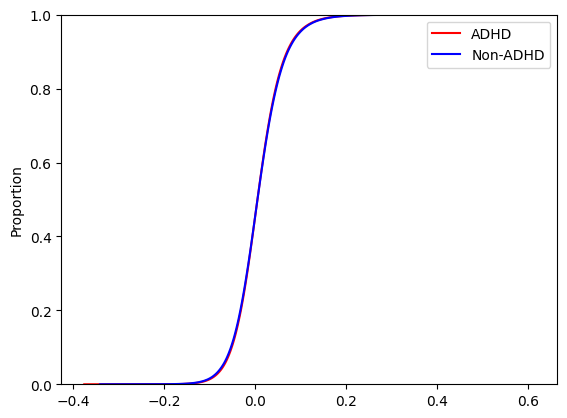

In [409]:
pd.Series(connectomes[:,ends_bool_array][adhd_idx].mean(axis=0)).hist(alpha=.5, bins=20, label='adhd')
pd.Series(connectomes[:,ends_bool_array][no_adhd_idx].mean(axis=0)).hist(alpha=.5, bins=20, label='no adhd')
plt.legend()

from scipy import stats
ks_stat, p_value = stats.ks_2samp(connectomes[:,ends_bool_array][adhd_idx].flatten(), connectomes[:,ends_bool_array][no_adhd_idx].flatten())
print(ks_stat)
print(p_value)
u_stat, p2_value = stats.mannwhitneyu(connectomes[:,ends_bool_array][adhd_idx].flatten(), connectomes[:,ends_bool_array][no_adhd_idx].flatten())
print(u_stat)
print(p2_value)

plt.figure()
sns.ecdfplot(connectomes[:,ends_bool_array][adhd_idx].flatten(), label="ADHD", color="red")
sns.ecdfplot(connectomes[:,ends_bool_array][no_adhd_idx].flatten(), label="Non-ADHD", color="blue")
plt.legend()

pairwise_diffs = (pd.Series(connectomes[:,ends_bool_array][adhd_idx].flatten()),\
                  pd.Series(connectomes[:,ends_bool_array][no_adhd_idx].flatten()),\
                  (pd.Series(connectomes[:,ends_bool_array][adhd_idx].flatten()) - pd.Series(connectomes[:,ends_bool_array][no_adhd_idx].flatten()))
                  )

In [413]:
connectomes[:,ends_bool_array][adhd_idx].mean(axis=0).mean() #- .005

0.00797510368986268

Text(0.5, 1.0, "at the extremes, what's the mean diff we're looking at between adhd and no adhd")

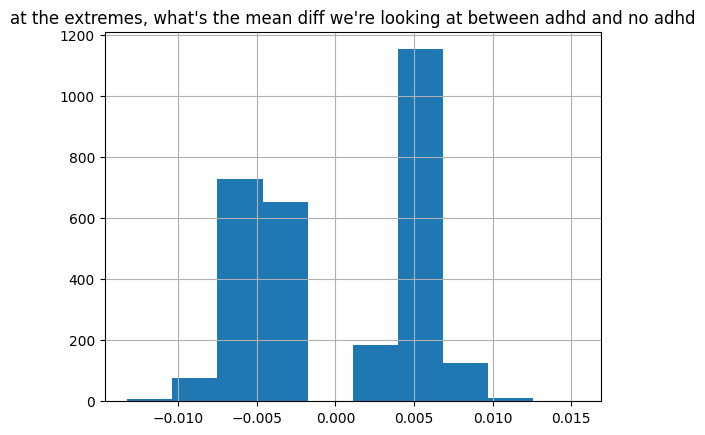

In [422]:
pd.Series((connectomes[:,ends_bool_array][adhd_idx].mean(axis=0) - connectomes[:,ends_bool_array][no_adhd_idx].mean(axis=0))).hist()

plt.title("at the extremes, what's the mean diff we're looking at between adhd and no adhd")
# plt.figure()
# pd.Series((connectomes[:,ends_bool_array][adhd_idx].mean(axis=0) - connectomes[:,ends_bool_array][no_adhd_idx].mean(axis=0))/\
#           connectomes[:,ends_bool_array][no_adhd_idx].mean(axis=0)).hist()
# plt.title("at the extremes, what's the mean percentage diff between adhd and no adhd")

In [399]:
solutions['ADHD_Outcome'].value_counts()

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

### UMAP

In [354]:
import umap 
reducer = umap.UMAP(random_state=42, n_neighbors=15, n_components=2)

In [355]:
# just to understand the data structure...
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape) # you call .fit() on this object..
print(digits.images.shape)

(1797, 64)
(1797, 8, 8)


In [356]:
digits.data[0] == digits.images[0].flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [357]:
vals.shape

(1213, 2942)

In [358]:
vals = connectomes[:,ends_bool_array]

In [359]:
reducer.fit(vals)

/Users/paigegiese/SYG/wids-2025-mupd/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [360]:
embedding = reducer.transform(vals)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape


(1213, 2)

In [361]:
embedding[:, 1]

array([5.182929 , 5.6256757, 5.6351485, ..., 5.7599835, 6.6131535,
       5.9251633], dtype=float32)

In [362]:
import plotly.express as px

Text(0.5, 1.0, 'UMAP projection of the 30-nearest, 2D representation of effect-size standardized dataset')

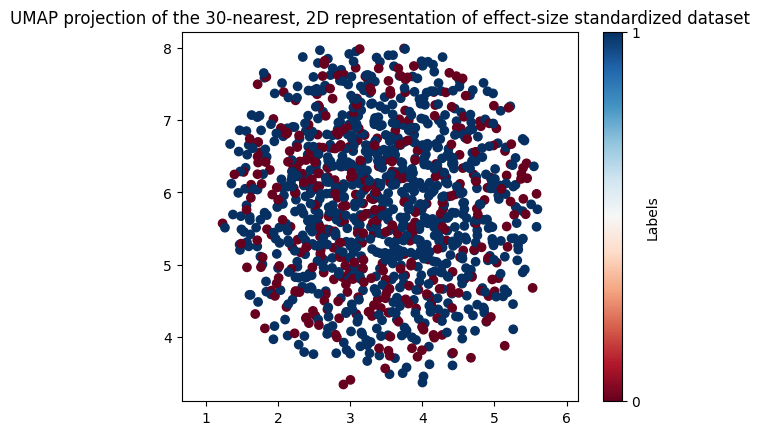

In [363]:
#plt.scatter(embedding[:, 0], embedding[:, 1], c=df_labeled['ADHD_Outcome'].values, cmap='Spectral', s=5)

plt.scatter(embedding[:, 0], embedding[:, 1], c=df_labeled['ADHD_Outcome'].values, 
            cmap=plt.cm.RdBu,  # Red-Blue diverging colormap
            norm=plt.Normalize(vmin=0, vmax=1))

plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(ticks=[0, 1], label='Labels')

plt.title('UMAP projection of the 30-nearest, 2D representation of effect-size standardized dataset')


In [351]:
embedding[:, 2].astype(float)

array([7.52198935, 7.7978611 , 7.82479906, ..., 8.72991657, 8.7835331 ,
       8.91709328])

In [352]:
import plotly.io as pio
pio.renderers.default = "browser"  # This can help if inline rendering fails

In [353]:
# Basic 3D scatter plot
fig = px.scatter_3d(
    x=embedding[:, 0].astype(float),  # First dimension
    y=embedding[:, 1].astype(float),  # Second dimension
    z=embedding[:, 2].astype(float),  # Third dimension
    color=df_labeled['ADHD_Outcome'].values.astype(int),       # Color by labels
    color_continuous_scale='RdBu',  # Red-Blue color scale for binary
    title='3D Scatter Plot of Effect Size Embedding'
)
fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    width=800,
    height=800
)

fig.show()

# df = pd.DataFrame({
#     'x': embedding[:, 0],
#     'y': embedding[:, 1],
#     'z': embedding[:, 2],
#     'label': df_labeled['ADHD_Outcome'].values.astype(int)
# })

# fig = px.scatter_3d(
#     df, 
#     x='x', 
#     y='y', 
#     z='z', 
#     color='label'
# )

# fig.show()

In [191]:
df

,x,y,z,label
0,5.949367,4.702104,3.770115,1
1,5.143324,4.410776,3.911810,1
2,5.256257,5.107381,4.491704,1
3,4.355971,4.911138,3.584879,1
4,4.934638,5.574514,3.887851,1
...,...,...,...,...
1208,3.654019,5.338695,3.524550,0
1209,4.294410,4.106596,3.264756,1
1210,4.416101,3.917753,3.314930,0
1211,3.936980,4.341074,3.120086,1


In [91]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# X = np.array([get_upper_triangle_features(conn) for conn in connectomes])
    
# # StandardScaler to handle small numeric values
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)




In [95]:
# # Elbow method to determine optimal number of clusters
# inertias = []
# max_clusters = 50
# for k in range(1, max_clusters + 1):
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)#, n_init=10)
#     kmeans.fit(X_scaled)
#     inertias.append(kmeans.inertia_)

# # Plot elbow curve
# plt.figure(figsize=(8, 8))
# plt.plot(range(1, max_clusters + 1), inertias, marker='o')
# plt.title('Elbow plot')
# plt.xlabel('# Clusters')
# plt.ylabel('Inertia')
# plt.show()

In [96]:
# # Choose optimal number of clusters based on the elbow plot
# optimal_k = 3  # This is a placeholder - you'll determine from the plot
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# cluster_labels = kmeans.fit_predict(X_scaled)

# # Visualize cluster distribution
# plt.figure(figsize=(10, 6))
# for i in range(optimal_k):
#     cluster_count = np.sum(cluster_labels == i)
#     plt.bar(i, cluster_count)
# plt.title('Cluster Distribution')
# plt.xlabel('Cluster')
# plt.ylabel('Number of Subjects')
# plt.show()

# # Optional: Examine how clusters relate to your original labels
# from sklearn.metrics import confusion_matrix
# print("Confusion Matrix (Clusters vs ADHD Labels):")
# print(confusion_matrix(adhd_labels, cluster_labels))

# Okay, so turns out clustering just isn't really working so well. BUMMER. I was hoping to see some cool stuff there. Perhaps I will do a little sampling

## Claude.ai attention-based NN

In [462]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, confusion_matrix
import torch
from imblearn.over_sampling import SMOTE


# Step 1: Set up the Attention Model
class AttentionBasedConnectivityModel(nn.Module):
    def __init__(self, num_connections, hidden_dim=32): # 64 hidden layers was causing overfitting on such a small dataset
        super(AttentionBasedConnectivityModel, self).__init__()
        
        # Attention mechanism
        self.attention = nn.Linear(num_connections, num_connections)
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_connections, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 2)  # Binary classification: ADHD or not
        
        self.dropout = nn.Dropout(0.6) #started at .5, increased to .6 to reduce overfitting
        
        # Store attention weights for later analysis
        self.last_attention_weights = None
    
    def forward(self, x):
        # Apply attention mechanism
        attention_scores = self.attention(x)
        self.last_attention_weights = F.softmax(attention_scores, dim=1)
        x_weighted = x * self.last_attention_weights
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x_weighted))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

# Step 2: Create Functions for Training and Evaluation
def train_model(model, train_loader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            pred = outputs.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return val_loss, val_acc, precision, recall, f1, all_preds, all_labels

# Step 3: Implement Cross-Validation Training Pipeline
def train_with_cross_validation(X, y, num_folds=5, batch_size=32, num_epochs=10, hidden_dim=32, lr=0.001):
    # Convert data to PyTorch tensors
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print(f'New x array size: {X_res.shape}, new y_label mean: {np.mean(y_res)}')
    X_tensor = torch.FloatTensor(X_res)
    y_tensor = torch.LongTensor(y_res)
    
    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize k-fold cross-validation
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Store results
    fold_results = []
    feature_importance = np.zeros(X.shape[1])
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nFold {fold+1}/{num_folds}")
        
        # Prepare data loaders for this fold
        X_train_fold, X_val_fold = X_tensor[train_idx], X_tensor[val_idx]
        y_train_fold, y_val_fold = y_tensor[train_idx], y_tensor[val_idx]
        
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Initialize model for this fold
        model = AttentionBasedConnectivityModel(num_connections=X.shape[1], hidden_dim=hidden_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Training loop
        best_val_acc = 0.0
        best_model_state = None
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, device, epoch)
            val_loss, val_acc, precision, recall, f1, _, _ = evaluate_model(model, val_loader, device)
            
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
        
        # Load best model for this fold and evaluate
        model.load_state_dict(best_model_state)
        val_loss, val_acc, precision, recall, f1, all_preds, all_labels = evaluate_model(model, val_loader, device)
        
            # Get predicted probabilities for class 1
        with torch.no_grad():
            val_probs = torch.softmax(model(X_val_fold.to(device)), dim=1)[:, 1].cpu().numpy()

        # Calculate precision-recall curve
        precision_vals, recall_vals, thresholds = precision_recall_curve(y_val_fold, val_probs)
        
        # Select the threshold where precision >= recall
        best_threshold_idx = (precision_vals >= recall_vals).argmax()
        best_threshold = thresholds[best_threshold_idx]
        
        # Adjust predictions based on the chosen threshold
        val_predictions = (val_probs >= best_threshold).astype(int)

        # Evaluate the model with the adjusted threshold
        precision_val = precision_vals[best_threshold_idx]
        recall_val = recall_vals[best_threshold_idx]
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)

        print(f"\nFold {fold+1} Results:")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Precision: {precision_val:.4f}")
        print(f"Recall: {recall_val:.4f}")
        print(f"F1 Score: {f1_val:.4f}")
        
        # Get confusion matrix
        cm = confusion_matrix(all_labels, val_predictions)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Extract attention weights for feature importance
        with torch.no_grad():
            inputs = X_tensor[val_idx].to(device)
            _ = model(inputs)
            fold_importance = model.last_attention_weights.mean(dim=0).cpu().numpy()
            feature_importance += fold_importance
        
        # Store results for this fold
        fold_results.append({
            "val_acc": val_acc,
            "precision": precision_val,
            "recall": recall_val,
            "f1": f1_val,
            "history": history,
            "confusion_matrix": cm
        })
    
    # Average feature importance across folds
    feature_importance /= num_folds
    
    return fold_results, feature_importance

# Step 4: Visualize Results Function
def visualize_results(fold_results, feature_importance, connection_names=None):
    # Calculate average metrics across folds
    avg_acc = np.mean([r["val_acc"] for r in fold_results])
    avg_precision = np.mean([r["precision"] for r in fold_results])
    avg_recall = np.mean([r["recall"] for r in fold_results])
    avg_f1 = np.mean([r["f1"] for r in fold_results])
    
    print("\nAverage Cross-Validation Results:")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for i, fold in enumerate(fold_results):
        plt.plot(fold["history"]["train_loss"], linestyle='--', alpha=0.5, label=f'Train Loss Fold {i+1}')
        plt.plot(fold["history"]["val_loss"], alpha=0.7, label=f'Val Loss Fold {i+1}')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, fold in enumerate(fold_results):
        plt.plot(fold["history"]["train_acc"], linestyle='--', alpha=0.5, label=f'Train Acc Fold {i+1}')
        plt.plot(fold["history"]["val_acc"], alpha=0.7, label=f'Val Acc Fold {i+1}')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    
    # Sort importance values
    sorted_idx = np.argsort(feature_importance)[::-1]
    sorted_importance = feature_importance[sorted_idx]
    
    # Use connection names if provided, otherwise use indices
    if connection_names is not None:
        sorted_labels = [connection_names[i] for i in sorted_idx]
    else:
        sorted_labels = [f"Connection {i}" for i in sorted_idx]
    
    # Plot top 20 features
    top_n = min(20, len(sorted_importance))
    plt.barh(range(top_n), sorted_importance[:top_n], align='center')
    plt.yticks(range(top_n), sorted_labels[:top_n])
    plt.gca().invert_yaxis()  # Display the highest importance at the top
    plt.title('Top Brain Connections by Importance')
    plt.xlabel('Attention Weight')
    plt.tight_layout()
    plt.show()
    
    return avg_acc, avg_precision, avg_recall, avg_f1

# Step 5: Main Execution Function
def run_adhd_classification(X, y, connection_names=None):
    """
    Main function to run the entire ADHD classification pipeline
    
    Parameters:
    X (numpy.ndarray): Feature matrix with connectivity values (upper triangle)
    y (numpy.ndarray): Labels (0: control, 1: ADHD)
    connection_names (list, optional): Names of each connection for visualization
    
    Returns:
    dict: Results including model performance and feature importance
    """
    print(f"Data shape: {X.shape}, Labels distribution: {np.bincount(y)}")
    
    # Set hyperparameters
    num_folds = 5
    batch_size = 32
    num_epochs = 10
    hidden_dim = 32
    learning_rate = 0.001
    
    # Run cross-validation
    fold_results, feature_importance = train_with_cross_validation(
        X, y, num_folds=num_folds, batch_size=batch_size, 
        num_epochs=num_epochs, hidden_dim=hidden_dim, lr=learning_rate
    )
    
    # Visualize results
    avg_acc, avg_precision, avg_recall, avg_f1 = visualize_results(
        fold_results, feature_importance, connection_names
    )
    output = {
        "avg_accuracy": avg_acc,
        "avg_precision": avg_precision,
        "avg_recall": avg_recall,
        "avg_f1": avg_f1,
        "fold_results": fold_results,
        "feature_importance": feature_importance,
        "sorted_features": np.argsort(feature_importance)[::-1].tolist()
    }
    
    # Return results
    return output

# Example usage:
# Assuming X contains the upper triangle connectivity data and y contains the labels
# X_upper_triangle = ...  # your prepared connectivity data
# y_labels = ...  # your binary labels (0: control, 1: ADHD)
# results = run_adhd_classification(X_upper_triangle, y_labels)


In [ ]:
def get_upper_triangle_features(matrix):
    # Get upper triangle indices
    indices = np.triu_indices_from(matrix, k=1)  # k=1 excludes diagonal
    # Return the values at these indices
    return matrix[indices]#, indices

In [437]:
xarray = np.array([get_upper_triangle_features(conn) for conn in connectomes])

In [456]:
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(xarray, y_labels)


In [441]:
y_labels = df_labeled['ADHD_Outcome'].values

Adjustments made:
- Needed to switch the threshold to one that better balances precision and recall (precision >= recall). The model was just initially predicting everyone to have ADHD because ~66% of the sample is ADHD =1
- Reduced hidden layers down to 32, rather than 64. Was horribly overfitting.
- Initial results after these adjustments were underwhelming: If TN, you'd get a positive class 50-66% of the time, if TP, you'd only get predicted positive 70% of the time. 

- Moving onto SMOTE to see if simple rebalancing gives us a better balance of ADHD. If we can minimize error here, we might be able to combine with other data in an ensemble style to get an overall more accurate prediction. 

In [463]:
results = run_adhd_classification(xarray, y_labels)

Data shape: (1213, 19701), Labels distribution: [382 831]
Using device: cpu

Fold 1/5


: 

: 